# Monthly Treasury Trade

## Packages

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\MonthlyTreasurySeasonality\root\src")
from MonthlyReturns import MonthlyReturns

In [3]:
df = MonthlyReturns().get_monthly_rtn()

## Returns Playback

In [4]:
def get_rtn(df: pd.DataFrame) -> pd.DataFrame:
    
    lookbacks = df.days.drop_duplicates().sort_values().to_list()
    df_out    = pd.DataFrame()

    for lookback in lookbacks:

        df_tmp = (df.query(
            "days <= @lookback")
            [["date", "PX_bps"]].
            groupby("date").
            agg("mean").
            assign(lookback = lookback))

        df_out = pd.concat([df_out, df_tmp])
    
    return df_out

df_rtn = get_rtn(df)

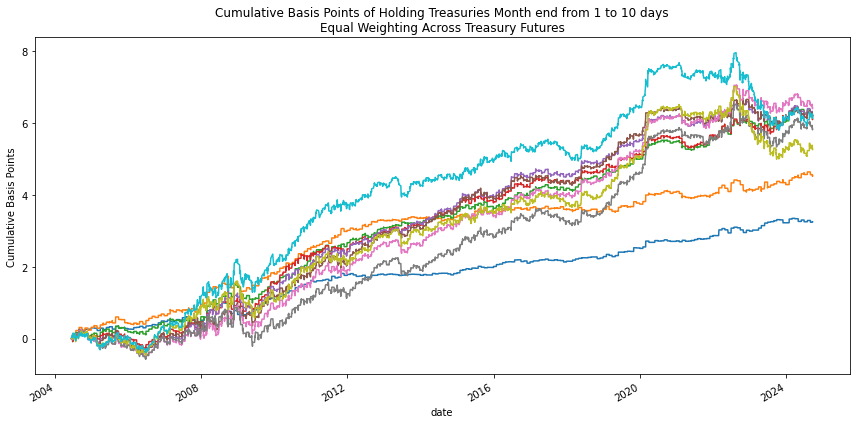

In [5]:
def plot_cumulative_rtn(df_rtn: pd.DataFrame) -> plt.Figure:     
    
    (df_rtn.reset_index().rename(
        columns = {"lookback": ""}).
        pivot(index = "date", columns = "", values = "PX_bps").
        fillna(0).
        cumsum().
        plot(
            legend  = False,
            figsize = (12,6),
            title   = "Cumulative Basis Points of Holding Treasuries Month end from 1 to 10 days\nEqual Weighting Across Treasury Futures",
            ylabel  = "Cumulative Basis Points"))
    
    plt.tight_layout()
    
plot_cumulative_rtn(df_rtn)

## Event Study

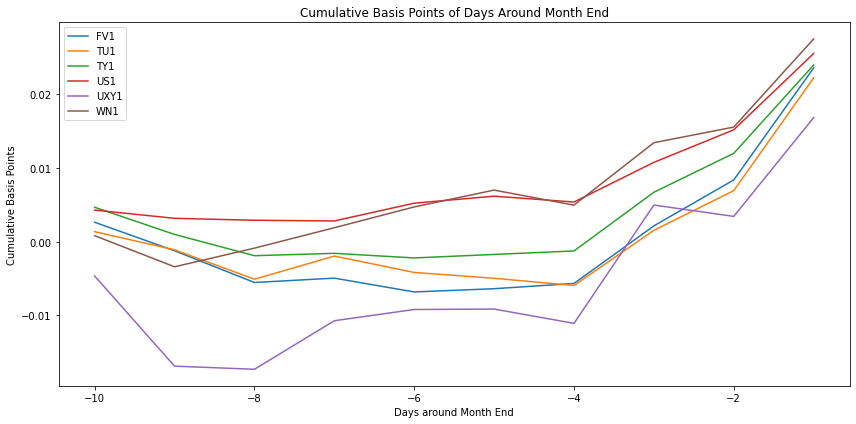

In [6]:
def plot_rtn_around_month_end(df: pd.DataFrame) -> plt.Figure: 

    (df.assign(
        days = lambda x: -x.days)
        [["days", "security", "PX_bps"]].
        groupby(["days", "security"]).
        agg("mean").
        reset_index().
        rename(columns = {"security": ""}).
        pivot(index = 'days', columns = "", values = "PX_bps").
        cumsum().
        plot(
            ylabel  = "Cumulative Basis Points",
            xlabel  = "Days around Month End",
            figsize = (12,6),
            title   = "Cumulative Basis Points of Days Around Month End"))
    
    plt.tight_layout()
    
plot_rtn_around_month_end(df)

In [7]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.assign(
        group_var = lambda x: x.group + " " + x.days.astype(str)))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    df_out     = pd.DataFrame()

    for group_var in group_vars:

        month_area, days = group_var.split()
        days             = int(days)

        df_add = (df.query(
            "group == @month_area").
            query("days <= @days").
            assign(signal_rtn = lambda x: np.where(month_area == "back", 1, -1) * x.PX_bps)
            [["security", "signal_rtn"]].
            groupby(["security"]).
            agg(["mean", "std"])
            ["signal_rtn"].
            rename(columns = {
                "mean": "mean_rtn",
                "std" : "std_rtn"}).
            assign(
                group      = month_area,
                day_window = days,
                sharpe     = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(12)))

        df_out = pd.concat([df_out, df_add])
        
    return df_out
    
df_sharpe = get_sharpe(df)

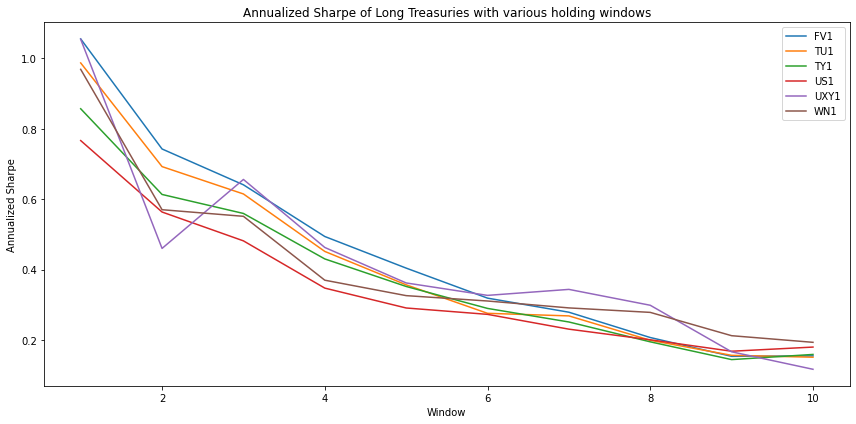

In [8]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_sharpe.reset_index().rename(
        columns = {"security": ""}).
        pivot(index = "day_window", columns = "", values = "sharpe").
        plot(
            ylabel  = "Annualized Sharpe",
            xlabel  = "Window",
            title   = "Annualized Sharpe of Long Treasuries with various holding windows",
            figsize = (12,6)))

    plt.tight_layout()
    
plot_sharpe(df_sharpe)

In [9]:
def get_oos_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.assign(
        group_var = lambda x: x.group + " " + x.days.astype(str) + " " + x.security))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    df_out     = pd.DataFrame()

    for group_var in group_vars:

        month_area, days, security = group_var.split()
        days                       = int(days)

        df_add = (df.query(
            "security == @security").
            query("group == @month_area").
            query("days <= @days").
            sort_values("date").
            assign(
                signal = lambda x: x.PX_bps.expanding().mean().shift(),
                signal_rtn = lambda x: np.sign(x.signal) * x.PX_bps)
            [["date", "security", "signal_rtn", "group"]].
            assign(days = days))

        df_out = pd.concat([df_out, df_add])
        
    return df_out

df_oos_rtn = get_oos_rtn(df)

In [10]:
def get_sharpe_comparison(df_rtn: pd.DataFrame, df_oos_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    lookbacks = df_rtn.lookback.drop_duplicates().sort_values().to_list()
    df_out    = pd.DataFrame()

    for lookback in lookbacks:

        oos_rtn = (df_oos_rtn.query(
            "days <= @lookback")
            [["date", "signal_rtn"]].
            groupby("date").
            agg("mean").
            signal_rtn)

        is_rtn = (df_rtn.query(
            "lookback == @lookback").
            PX_bps)

        is_sharpe  = is_rtn.mean() / is_rtn.std() * np.sqrt(12)
        oos_sharpe = oos_rtn.mean() / oos_rtn.std() * np.sqrt(12)
        df_tmp     = (pd.DataFrame(
            {
                "sharpe": [is_sharpe, oos_sharpe],
                "group" : ["in_sample", "out_sample"]}).
            assign(lookback = lookback))

        df_out = pd.concat([df_out, df_tmp])
        
    return df_out

df_sharpe_comparison = get_sharpe_comparison(df_rtn, df_oos_rtn)

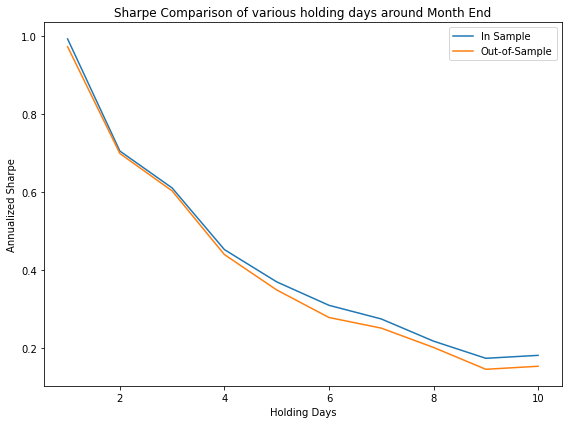

In [11]:
def plot_sharpe_comparison(df_sharpe_comparison: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe_comparison.rename(
        columns = {"group": ""}).
        pivot(index = "lookback", columns = "", values = "sharpe").
        rename(columns = {
            "in_sample" : "In Sample",
            "out_sample": "Out-of-Sample"}).
        plot(
            ylabel  = "Annualized Sharpe",
            title   = "Sharpe Comparison of various holding days around Month End",
            xlabel  = "Holding Days",
            figsize = (8,6)))

    plt.tight_layout()
    
plot_sharpe_comparison(df_sharpe_comparison)